In [1]:
%matplotlib inline

In [2]:
import sys
import numpy as np
import pandas as pd
from sklearn import linear_model
import matplotlib.pyplot as plt

from pyspark import SparkContext
from pyspark.sql import SQLContext, Row
from pyspark.sql.types import *

sqlContext = SQLContext(sc)

In [3]:
ad = sc.textFile( "gs://adlog/demo/ad/*" )
adlogs = ad.map( lambda s: s.split(',') ) \
             .filter( lambda s: s[0] != 'req_id' ) \
             .map( lambda s: Row(
                    id                = s[0],
                    date           = s[3],
                    hour           = s[4],
                    os               = s[9],
                    version       = int(s[7][0]) if len(s[7]) > 0 else 0,
                    categoryId = int(s[10]),
                    category    = s[11] ) )

In [4]:
adsc = sqlContext.inferSchema( adlogs )
adsc.registerTempTable( "adlogs" )

In [5]:
click = sc.textFile( "gs://adlog/demo/click/*" )
clicklogs = click.map( lambda s: s.split(',') ) \
             .filter( lambda s: s[0] != 'req_id' ) \
             .map( lambda s: Row(
                    id                = s[0],
                    date           = s[3],
                    hour           = s[7] ) )

In [6]:
clicksc = sqlContext.inferSchema( clicklogs )
clicksc.registerTempTable( "clicklogs" )

In [7]:
aggs = sqlContext.sql("""\
select
     a.categoryId
    ,a.category
    ,a.os
    ,a.version
    ,count(1) as num
    ,SUM(case when c.id is not null then 1 else 0 end) as click
from
    adlogs as a
    left join
      clicklogs as c
      on c.id = a.id
group by
     a.categoryId
    ,a.category
    ,a.os
    ,a.version
""")

In [8]:
df = aggs.toPandas()

In [9]:
osmap = {
    'iOS': 1.0,
    'Android': 2.0,
    'PC': 0.0
}

In [10]:
grouped = df.groupby(['category'])
categories = grouped[['categoryId']].max()

In [11]:
df['click_rate'] = df.apply( lambda x: float(x['click']) / float(x['num']) * 100, axis=1 )
df['os_f'] = df.apply( lambda x: osmap[x['os']], axis=1 )

In [12]:
sr = df.sort(['click_rate'], ascending = False)
print sr[0:10]

     categoryId   category       os  version    num  click  click_rate  os_f
150          64     エステサロン  Android        4    455      1    0.219780     2
51           64     エステサロン      iOS        6   1558      1    0.064185     1
103          35    銀行・信用金庫      iOS        8   6287      4    0.063623     1
177         131       電子書籍      iOS        8  75888     30    0.039532     1
176         131       電子書籍      iOS        7  25762      6    0.023290     1
124          68    その他（美容）      iOS        7   9695      2    0.020629     1
175          37      消費者金融      iOS        8  27736      4    0.014422     1
64           15  人材サービス　全般      iOS        8  73640     10    0.013580     1
22           68    その他（美容）  Android        4  19504      2    0.010254     2
126          68    その他（美容）      iOS        8  29961      3    0.010013     1


In [13]:
X = df[['categoryId', 'os_f', 'click_rate']]
y = df.version

In [14]:
clf = linear_model.LogisticRegression(C=1.0, penalty='l1', tol=0.01)
clf.fit( X, y )

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, penalty='l1', random_state=None, tol=0.01)

In [15]:
X2 = pd.DataFrame( { 'categoryId': [categories.ix[u'エステサロン', 0]], 'os_f': [osmap['iOS']], 'click_rate': [0.5] }  )
predict_y = clf.predict( X2 )
print predict_y

[7]


In [16]:
vers = df.groupby(['version'])
y2 = vers[['click_rate']].mean()

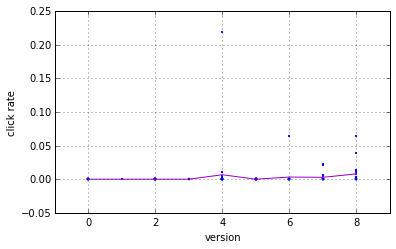

In [17]:
fig, rate = plt.subplots()
fig.subplots_adjust( bottom=0.2 )

plt.scatter( y, X.click_rate, color='blue', marker='.', linewidths=0 )
plt.plot( y2.index, y2.click_rate, color='#9900CC', linewidth=1.0 )
#line.set_ylabel('categoryId')
#plt.plot( X.click_rate, y, color='red', linestyle='solid', linewidth=2 )

plt.grid( True )
plt.xlabel( 'version' )
plt.ylabel( 'click rate' )
plt.show()
plt.clf()